#  Standalone DDPM

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision import datasets as dtsets
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import os
import random
import time
import matplotlib.pyplot as plt
import math

## Set Random Seed

In [2]:
def set_seed(seed=2400, loader=None):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    try:
        loader.sampler.generator.manual_seed(seed)
    except AttributeError:
        pass

In [3]:
set_seed(seed=2400, loader=None)

## Load Data

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
IMG_SIZE = 64

In [5]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

def save_tensor_image(tensor, filename):
    tensor = tensor.clone().detach().squeeze(0)
    image = transforms.ToPILImage()(tensor)
    image.save(filename)

In [7]:
def show_tensor_image(image):
    '''
    Plots image after applying reverse transformations.
    '''
    image = image.detach().cpu()
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

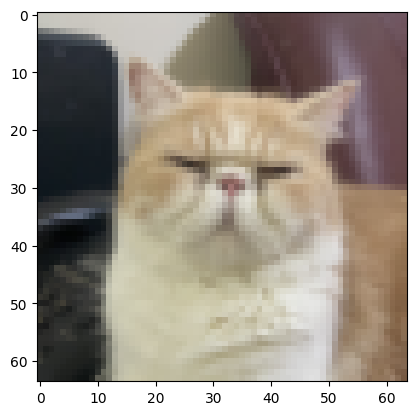

In [8]:
data = load_image("./data/mycat.jpg")
show_tensor_image(data)

In [9]:
from skimage.metrics import structural_similarity as ssim

def get_ssim(img1, img2):
    img1 = img1.detach().to('cpu').numpy()
    img2 = img2.detach().to('cpu').numpy()

    img1 = np.transpose(img1.squeeze(), (1, 2, 0))
    img2 = np.transpose(img2.squeeze(), (1, 2, 0))
    
    # calculate SSIM for each channel
    ssim_score, _ = ssim(img1, img2, win_size=3, multichannel=True, full=True, data_range=1.0)
    return ssim_score

## DDPM

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        h = self.bn1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        
        h = self.bn2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeds = math.log(10000) / (half_dim - 1)
        embeds = torch.exp(torch.arange(half_dim, device=device) * -embeds)
        embeds = time[:, None] * embeds[None, :]
        embeds = torch.cat((embeds.sin(), embeds.cos()), dim=-1)
        return embeds


class DDPM_Model(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                PositionalEncoding(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([ConvBlock(down_channels[i], down_channels[i+1], 
                                    time_emb_dim) for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([ConvBlock(up_channels[i], up_channels[i+1],
                                        time_emb_dim, up=True) for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        
        # Embedd time
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [11]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

In [12]:
# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = torch.nn.functional.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [13]:
def get_index_from_list(vals, t, x_shape):

    """
    Returns values from vals for corresponding timesteps
    while considering the batch dimension.

    """
    batch_size = t.shape[0]
    output = vals.gather(-1, t.cpu())
    return output.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [14]:
def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it after adding noise t times.
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)

    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

In [15]:
def get_loss(model, x_0, t, betas):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy.to(device), t)
    return nn.MSELoss()(noise_pred, noise)

In [16]:
def sample_timestep(model, x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean, model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean, model_mean + torch.sqrt(posterior_variance_t) * noise

In [17]:
def sample_plot_image(model, input_data):
    img_size = IMG_SIZE
    
    img = torch.randn((1, 3, img_size, img_size), device=device)
    img_noisy = img
    
    plt.figure(figsize=(20,2))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)
    DDPM_time = 0
    
    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        start = time.time()
        img, img_noisy = sample_timestep(model, img_noisy, t)
        end = time.time()
        DDPM_time = DDPM_time + (end-start)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize+1))
            show_tensor_image(img.detach().cpu())
    plt.show()
    score = get_ssim(img, data)
    print(f"total generation time = {DDPM_time:.6f}")
    print(f"SSIM score: {score:.4f}")
    print("---------------------------------------------------------")

    return score

In [18]:
def train_ddpm(input_data, num_epochs=100, save_every=10, T=300):
    model = DDPM_Model().to(device)
    model.train()
    
    loss_history = []
    ssim_history = []
    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    betas = linear_beta_schedule(timesteps=T)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        t = torch.randint(0, len(betas), (1,), device=device).long()
        loss = get_loss(model, input_data, t, betas)
        loss.backward()
        optimizer.step()

        loss_history.append(loss)
        
        if epoch % save_every == 0:
            print(f"Epoch {epoch:<3d}: Loss: {loss:.4f}")
            ssim_score = sample_plot_image(model, input_data)
            ssim_history.append(ssim_score)

    return loss_history, ssim_history

In [ ]:
DDPM_loss_history, DDPM_ssim_history = train_ddpm(data, num_epochs=1001, save_every=10, T=300)

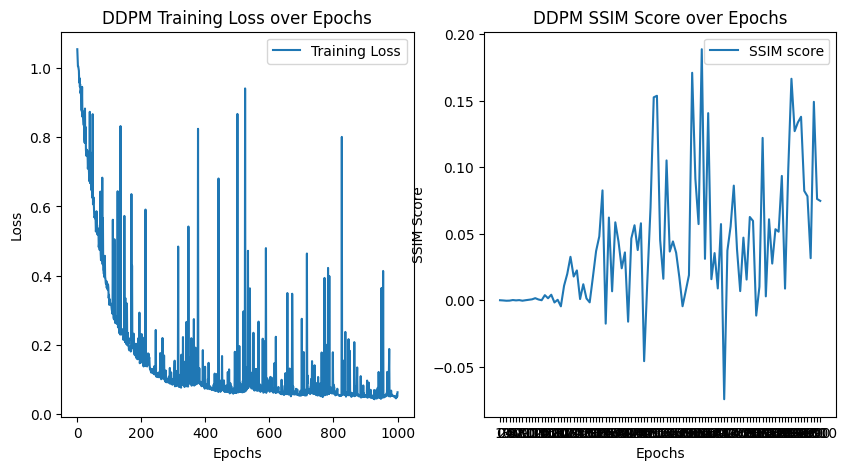

In [20]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(torch.tensor(DDPM_loss_history, device="cpu"), label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("DDPM Training Loss over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(torch.tensor(DDPM_ssim_history, device="cpu"), label="SSIM score")
plt.xlabel("Epochs")
plt.ylabel("SSIM Score")
plt.title("DDPM SSIM Score over Epochs")
plt.xticks(ticks=range(0,len(DDPM_ssim_history)), labels=range(0,len(DDPM_ssim_history)*10, 10))
plt.legend()

plt.show()